## Convert time series to image 
Based on https://gist.github.com/oguiza/c9c373aec07b96047d1ba484f23b7b47
and https://www.tensorflow.org/tutorials/load_data/images
and https://www.tensorflow.org/tutorials/images/transfer_learning

In [4]:
%config IPCompleter.greedy=True
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.preprocessing import minmax_scale

df_train = pd.read_csv('train_kaggle.csv')
df_test = pd.read_csv('sample_solution.csv')
Y = df_train['Label'].values

In [2]:
dataframes = np.load('allData.npy', allow_pickle = True)

def load_test_dataframe(id):
    test_data = np.load("test/test/{}.npy".format(id))
    return test_data


for i in range(len(dataframes)):
    dataframes[i] = minmax_scale(dataframes[i])

testdatas = []
for id in df_test['Id']:
    dfi = minmax_scale(load_test_dataframe(id))
    testdatas.append(dfi)

In [3]:
from pyts.multivariate.image import JointRecurrencePlot
from tqdm import tqdm

transformer = JointRecurrencePlot()
def convert_to_image(dfs):
    data = []
    for i in tqdm(range(len(dfs))):
        df = transformer.transform(dfs[i].reshape(1,dfs[i].shape[0],dfs[i].shape[1]))
        data.append(df)
    data = np.stack(data)
    return data

In [4]:
XTrain = convert_to_image(dataframes)

100%|█████████████████████████████████████████████████| 18662/18662 [1:19:13<00:00,  3.93it/s]


In [5]:
XTest = convert_to_image(testdatas)

100%|█████████████████████████████████████████████████████| 6051/6051 [19:24<00:00,  5.19it/s]


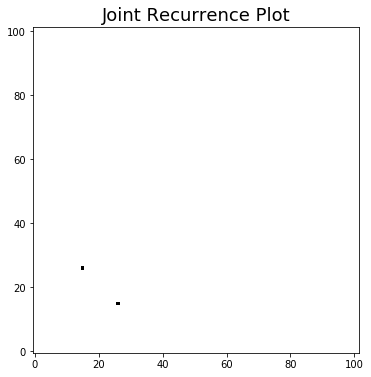

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.imshow(XTrain[0][0], cmap='binary', origin='lower')
plt.title('Joint Recurrence Plot', fontsize=18)
plt.show()

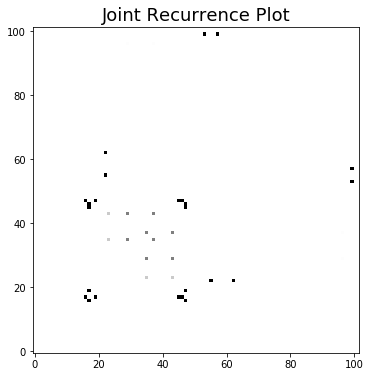

In [7]:
plt.figure(figsize=(6, 6))
plt.imshow(XTrain[1][0], cmap='binary', origin='lower')
plt.title('Joint Recurrence Plot', fontsize=18)
plt.show()

In [8]:
np.save('XTrain_image.npy', XTrain)

In [9]:
np.save('XTest_image.npy', XTest)

In [5]:
XTrain = np.load('XTrain_image.npy', allow_pickle = True)
XTest = np.load('XTest_image.npy', allow_pickle = True)

In [6]:
XTrain = XTrain.reshape((XTrain.shape[0], XTrain.shape[2], XTrain.shape[3]))
XTrain.shape

(18662, 102, 102)

In [7]:
XTest = XTest.reshape((XTest.shape[0], XTest.shape[2], XTest.shape[3]))
XTest.shape

(6051, 102, 102)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(XTrain, Y, test_size=0.2, random_state=42)

### Use CNN

In [19]:
import tensorflow as tf
from tensorflow import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

inputs = keras.Input(shape=(XTrain.shape[1], XTrain.shape[2])) 
x = tf.reshape(inputs, (-1, 1, XTrain.shape[1], XTrain.shape[2]))
x = keras.layers.Convolution2D(100, (3, 3), activation='relu', data_format='channels_first')(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Convolution2D(100, (3, 3),activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=x)

model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=METRICS)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Take a look at the model summary
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 102, 102)]        0         
_________________________________________________________________
tf_op_layer_Reshape_2 (Tenso [(None, 1, 102, 102)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 100)     1000      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 100)       0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 50, 100)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 48, 48, 100)       90100     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 100)       0   

In [20]:
EPOCHS = 100
baseline_history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_val, y_val),
    shuffle=True)

Train on 14929 samples, validate on 3733 samples
Epoch 1/100


 4320/14929 [=======>......................] - ETA: 29:24 - loss: 0.6939 - accuracy: 0.4375 - auc: 0.394 - ETA: 22:27 - loss: 0.6912 - accuracy: 0.4844 - auc: 0.564 - ETA: 20:09 - loss: 0.6825 - accuracy: 0.5521 - auc: 0.613 - ETA: 18:54 - loss: 0.6796 - accuracy: 0.5703 - auc: 0.614 - ETA: 18:24 - loss: 0.6592 - accuracy: 0.6000 - auc: 0.658 - ETA: 18:06 - loss: 0.6620 - accuracy: 0.5938 - auc: 0.652 - ETA: 17:42 - loss: 0.6619 - accuracy: 0.5804 - auc: 0.639 - ETA: 17:32 - loss: 0.6549 - accuracy: 0.5977 - auc: 0.653 - ETA: 17:22 - loss: 0.6486 - accuracy: 0.6181 - auc: 0.679 - ETA: 17:08 - loss: 0.6364 - accuracy: 0.6344 - auc: 0.692 - ETA: 17:02 - loss: 0.6376 - accuracy: 0.6392 - auc: 0.687 - ETA: 17:04 - loss: 0.6265 - accuracy: 0.6510 - auc: 0.699 - ETA: 17:01 - loss: 0.6216 - accuracy: 0.6538 - auc: 0.698 - ETA: 16:56 - loss: 0.6080 - accuracy: 0.6652 - auc: 0.712 - ETA: 16:54 - loss: 0.5964 - accuracy: 0.6646 - auc: 0.721 - ETA: 16:48 - loss: 0.5940 - accuracy: 0.6680 - auc: 0

14929/14929 [==============================] - ETA: 1:45 - loss: 0.4357 - accuracy: 0.8068 - auc: 0.85 - ETA: 1:43 - loss: 0.4360 - accuracy: 0.8069 - auc: 0.85 - ETA: 1:41 - loss: 0.4358 - accuracy: 0.8071 - auc: 0.85 - ETA: 1:39 - loss: 0.4358 - accuracy: 0.8071 - auc: 0.85 - ETA: 1:37 - loss: 0.4358 - accuracy: 0.8071 - auc: 0.85 - ETA: 1:35 - loss: 0.4358 - accuracy: 0.8071 - auc: 0.85 - ETA: 1:33 - loss: 0.4358 - accuracy: 0.8072 - auc: 0.85 - ETA: 1:30 - loss: 0.4361 - accuracy: 0.8071 - auc: 0.84 - ETA: 1:28 - loss: 0.4360 - accuracy: 0.8070 - auc: 0.84 - ETA: 1:26 - loss: 0.4358 - accuracy: 0.8072 - auc: 0.85 - ETA: 1:24 - loss: 0.4360 - accuracy: 0.8071 - auc: 0.84 - ETA: 1:22 - loss: 0.4359 - accuracy: 0.8070 - auc: 0.85 - ETA: 1:20 - loss: 0.4358 - accuracy: 0.8072 - auc: 0.85 - ETA: 1:18 - loss: 0.4358 - accuracy: 0.8072 - auc: 0.85 - ETA: 1:16 - loss: 0.4355 - accuracy: 0.8073 - auc: 0.85 - ETA: 1:14 - loss: 0.4357 - accuracy: 0.8074 - auc: 0.85 - ETA: 1:12 - loss: 0.4353 

 4352/14929 [=======>......................] - ETA: 15:55 - loss: 0.4259 - accuracy: 0.8125 - auc: 0.886 - ETA: 15:49 - loss: 0.3606 - accuracy: 0.8281 - auc: 0.912 - ETA: 15:43 - loss: 0.4284 - accuracy: 0.7812 - auc: 0.875 - ETA: 15:38 - loss: 0.4101 - accuracy: 0.7969 - auc: 0.876 - ETA: 15:34 - loss: 0.4168 - accuracy: 0.7937 - auc: 0.868 - ETA: 15:37 - loss: 0.4068 - accuracy: 0.8021 - auc: 0.866 - ETA: 15:35 - loss: 0.4009 - accuracy: 0.8170 - auc: 0.879 - ETA: 15:31 - loss: 0.3943 - accuracy: 0.8242 - auc: 0.881 - ETA: 15:29 - loss: 0.4070 - accuracy: 0.8194 - auc: 0.873 - ETA: 15:26 - loss: 0.3904 - accuracy: 0.8281 - auc: 0.884 - ETA: 15:22 - loss: 0.3936 - accuracy: 0.8239 - auc: 0.882 - ETA: 15:19 - loss: 0.3925 - accuracy: 0.8229 - auc: 0.882 - ETA: 15:21 - loss: 0.3959 - accuracy: 0.8221 - auc: 0.883 - ETA: 15:20 - loss: 0.4024 - accuracy: 0.8192 - auc: 0.879 - ETA: 15:19 - loss: 0.3932 - accuracy: 0.8271 - auc: 0.885 - ETA: 15:20 - loss: 0.3926 - accuracy: 0.8262 - auc: 0

14929/14929 [==============================] - ETA: 2:01 - loss: 0.3842 - accuracy: 0.8376 - auc: 0.88 - ETA: 1:58 - loss: 0.3837 - accuracy: 0.8378 - auc: 0.88 - ETA: 1:56 - loss: 0.3840 - accuracy: 0.8376 - auc: 0.88 - ETA: 1:53 - loss: 0.3841 - accuracy: 0.8374 - auc: 0.88 - ETA: 1:51 - loss: 0.3845 - accuracy: 0.8372 - auc: 0.88 - ETA: 1:49 - loss: 0.3842 - accuracy: 0.8373 - auc: 0.88 - ETA: 1:46 - loss: 0.3843 - accuracy: 0.8373 - auc: 0.88 - ETA: 1:44 - loss: 0.3845 - accuracy: 0.8372 - auc: 0.88 - ETA: 1:41 - loss: 0.3846 - accuracy: 0.8370 - auc: 0.88 - ETA: 1:39 - loss: 0.3849 - accuracy: 0.8368 - auc: 0.88 - ETA: 1:36 - loss: 0.3852 - accuracy: 0.8366 - auc: 0.88 - ETA: 1:34 - loss: 0.3848 - accuracy: 0.8370 - auc: 0.88 - ETA: 1:32 - loss: 0.3850 - accuracy: 0.8368 - auc: 0.88 - ETA: 1:29 - loss: 0.3850 - accuracy: 0.8368 - auc: 0.88 - ETA: 1:27 - loss: 0.3851 - accuracy: 0.8366 - auc: 0.88 - ETA: 1:24 - loss: 0.3851 - accuracy: 0.8366 - auc: 0.88 - ETA: 1:22 - loss: 0.3854 

 4352/14929 [=======>......................] - ETA: 15:51 - loss: 0.3467 - accuracy: 0.8750 - auc: 0.866 - ETA: 15:37 - loss: 0.3346 - accuracy: 0.8906 - auc: 0.881 - ETA: 15:31 - loss: 0.3776 - accuracy: 0.8646 - auc: 0.897 - ETA: 15:30 - loss: 0.3989 - accuracy: 0.8438 - auc: 0.875 - ETA: 15:26 - loss: 0.3819 - accuracy: 0.8562 - auc: 0.881 - ETA: 15:22 - loss: 0.3768 - accuracy: 0.8594 - auc: 0.881 - ETA: 15:29 - loss: 0.3783 - accuracy: 0.8571 - auc: 0.878 - ETA: 15:28 - loss: 0.3708 - accuracy: 0.8594 - auc: 0.881 - ETA: 15:24 - loss: 0.3470 - accuracy: 0.8715 - auc: 0.896 - ETA: 15:20 - loss: 0.3480 - accuracy: 0.8687 - auc: 0.896 - ETA: 15:18 - loss: 0.3446 - accuracy: 0.8722 - auc: 0.899 - ETA: 15:17 - loss: 0.3326 - accuracy: 0.8776 - auc: 0.905 - ETA: 15:13 - loss: 0.3411 - accuracy: 0.8678 - auc: 0.901 - ETA: 15:11 - loss: 0.3457 - accuracy: 0.8661 - auc: 0.899 - ETA: 15:12 - loss: 0.3396 - accuracy: 0.8687 - auc: 0.902 - ETA: 15:11 - loss: 0.3529 - accuracy: 0.8594 - auc: 0

14929/14929 [==============================] - ETA: 1:52 - loss: 0.3636 - accuracy: 0.8496 - auc: 0.89 - ETA: 1:50 - loss: 0.3634 - accuracy: 0.8497 - auc: 0.89 - ETA: 1:48 - loss: 0.3632 - accuracy: 0.8498 - auc: 0.89 - ETA: 1:46 - loss: 0.3633 - accuracy: 0.8496 - auc: 0.89 - ETA: 1:43 - loss: 0.3637 - accuracy: 0.8493 - auc: 0.89 - ETA: 1:41 - loss: 0.3634 - accuracy: 0.8495 - auc: 0.89 - ETA: 1:39 - loss: 0.3631 - accuracy: 0.8498 - auc: 0.89 - ETA: 1:37 - loss: 0.3628 - accuracy: 0.8500 - auc: 0.89 - ETA: 1:34 - loss: 0.3630 - accuracy: 0.8499 - auc: 0.89 - ETA: 1:32 - loss: 0.3631 - accuracy: 0.8498 - auc: 0.89 - ETA: 1:30 - loss: 0.3630 - accuracy: 0.8498 - auc: 0.89 - ETA: 1:28 - loss: 0.3630 - accuracy: 0.8497 - auc: 0.89 - ETA: 1:25 - loss: 0.3627 - accuracy: 0.8499 - auc: 0.89 - ETA: 1:23 - loss: 0.3627 - accuracy: 0.8500 - auc: 0.89 - ETA: 1:21 - loss: 0.3626 - accuracy: 0.8501 - auc: 0.89 - ETA: 1:18 - loss: 0.3628 - accuracy: 0.8498 - auc: 0.89 - ETA: 1:16 - loss: 0.3629 

 4352/14929 [=======>......................] - ETA: 18:48 - loss: 0.3350 - accuracy: 0.8438 - auc: 0.970 - ETA: 18:25 - loss: 0.4005 - accuracy: 0.8125 - auc: 0.919 - ETA: 17:49 - loss: 0.3678 - accuracy: 0.8229 - auc: 0.924 - ETA: 18:34 - loss: 0.3443 - accuracy: 0.8359 - auc: 0.921 - ETA: 18:47 - loss: 0.3337 - accuracy: 0.8500 - auc: 0.923 - ETA: 18:46 - loss: 0.3167 - accuracy: 0.8594 - auc: 0.929 - ETA: 18:52 - loss: 0.3176 - accuracy: 0.8616 - auc: 0.922 - ETA: 18:48 - loss: 0.3494 - accuracy: 0.8477 - auc: 0.907 - ETA: 18:49 - loss: 0.3437 - accuracy: 0.8472 - auc: 0.912 - ETA: 18:43 - loss: 0.3518 - accuracy: 0.8406 - auc: 0.907 - ETA: 18:42 - loss: 0.3535 - accuracy: 0.8409 - auc: 0.907 - ETA: 18:39 - loss: 0.3567 - accuracy: 0.8411 - auc: 0.905 - ETA: 18:36 - loss: 0.3495 - accuracy: 0.8462 - auc: 0.906 - ETA: 18:36 - loss: 0.3487 - accuracy: 0.8504 - auc: 0.905 - ETA: 18:33 - loss: 0.3555 - accuracy: 0.8500 - auc: 0.901 - ETA: 18:32 - loss: 0.3577 - accuracy: 0.8496 - auc: 0

14929/14929 [==============================] - ETA: 1:47 - loss: 0.3538 - accuracy: 0.8540 - auc: 0.90 - ETA: 1:45 - loss: 0.3535 - accuracy: 0.8541 - auc: 0.90 - ETA: 1:43 - loss: 0.3538 - accuracy: 0.8538 - auc: 0.90 - ETA: 1:41 - loss: 0.3537 - accuracy: 0.8538 - auc: 0.90 - ETA: 1:39 - loss: 0.3538 - accuracy: 0.8538 - auc: 0.90 - ETA: 1:36 - loss: 0.3537 - accuracy: 0.8538 - auc: 0.90 - ETA: 1:34 - loss: 0.3536 - accuracy: 0.8539 - auc: 0.90 - ETA: 1:32 - loss: 0.3535 - accuracy: 0.8539 - auc: 0.90 - ETA: 1:30 - loss: 0.3538 - accuracy: 0.8537 - auc: 0.90 - ETA: 1:28 - loss: 0.3536 - accuracy: 0.8538 - auc: 0.90 - ETA: 1:25 - loss: 0.3539 - accuracy: 0.8536 - auc: 0.90 - ETA: 1:23 - loss: 0.3540 - accuracy: 0.8536 - auc: 0.90 - ETA: 1:21 - loss: 0.3540 - accuracy: 0.8536 - auc: 0.90 - ETA: 1:19 - loss: 0.3545 - accuracy: 0.8533 - auc: 0.90 - ETA: 1:17 - loss: 0.3543 - accuracy: 0.8533 - auc: 0.90 - ETA: 1:15 - loss: 0.3542 - accuracy: 0.8534 - auc: 0.90 - ETA: 1:12 - loss: 0.3540 

 4352/14929 [=======>......................] - ETA: 16:34 - loss: 0.2225 - accuracy: 0.9688 - auc: 0.995 - ETA: 16:06 - loss: 0.3143 - accuracy: 0.8906 - auc: 0.926 - ETA: 15:55 - loss: 0.3292 - accuracy: 0.8958 - auc: 0.920 - ETA: 15:53 - loss: 0.3545 - accuracy: 0.8828 - auc: 0.901 - ETA: 15:50 - loss: 0.3696 - accuracy: 0.8687 - auc: 0.900 - ETA: 15:45 - loss: 0.4030 - accuracy: 0.8438 - auc: 0.881 - ETA: 15:44 - loss: 0.3839 - accuracy: 0.8571 - auc: 0.890 - ETA: 15:43 - loss: 0.4077 - accuracy: 0.8438 - auc: 0.877 - ETA: 15:40 - loss: 0.3922 - accuracy: 0.8507 - auc: 0.884 - ETA: 15:37 - loss: 0.4077 - accuracy: 0.8375 - auc: 0.881 - ETA: 15:34 - loss: 0.3917 - accuracy: 0.8438 - auc: 0.888 - ETA: 15:33 - loss: 0.3938 - accuracy: 0.8464 - auc: 0.887 - ETA: 15:31 - loss: 0.3903 - accuracy: 0.8486 - auc: 0.886 - ETA: 15:30 - loss: 0.3876 - accuracy: 0.8504 - auc: 0.885 - ETA: 15:29 - loss: 0.3837 - accuracy: 0.8521 - auc: 0.886 - ETA: 15:26 - loss: 0.3786 - accuracy: 0.8555 - auc: 0

14929/14929 [==============================] - ETA: 1:38 - loss: 0.3530 - accuracy: 0.8547 - auc: 0.90 - ETA: 1:36 - loss: 0.3531 - accuracy: 0.8546 - auc: 0.90 - ETA: 1:34 - loss: 0.3531 - accuracy: 0.8547 - auc: 0.90 - ETA: 1:32 - loss: 0.3531 - accuracy: 0.8547 - auc: 0.90 - ETA: 1:30 - loss: 0.3528 - accuracy: 0.8548 - auc: 0.90 - ETA: 1:28 - loss: 0.3527 - accuracy: 0.8548 - auc: 0.90 - ETA: 1:26 - loss: 0.3526 - accuracy: 0.8548 - auc: 0.90 - ETA: 1:24 - loss: 0.3523 - accuracy: 0.8550 - auc: 0.90 - ETA: 1:22 - loss: 0.3521 - accuracy: 0.8550 - auc: 0.90 - ETA: 1:20 - loss: 0.3521 - accuracy: 0.8549 - auc: 0.90 - ETA: 1:18 - loss: 0.3522 - accuracy: 0.8549 - auc: 0.90 - ETA: 1:16 - loss: 0.3522 - accuracy: 0.8549 - auc: 0.90 - ETA: 1:14 - loss: 0.3524 - accuracy: 0.8547 - auc: 0.90 - ETA: 1:12 - loss: 0.3522 - accuracy: 0.8548 - auc: 0.90 - ETA: 1:10 - loss: 0.3519 - accuracy: 0.8550 - auc: 0.90 - ETA: 1:08 - loss: 0.3516 - accuracy: 0.8552 - auc: 0.90 - ETA: 1:06 - loss: 0.3515 

KeyboardInterrupt: 

In [21]:
YTest = model.predict(XTest)
df_test['Predicted'] = YTest[:, 0]
df_test

,Id,Predicted
0,0,0.835289
1,1,0.649739
2,2,0.386642
3,3,0.588804
4,4,0.663133
5,5,0.828460
6,6,0.000994
7,7,0.712606
8,8,0.829721
9,9,0.933630


In [22]:
df_test.to_csv('test.csv', index=False)

## Save as real image

In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

def save_as_image(data, folder, y = []):
    y = np.array(y)
    for i in tqdm(range(data.shape[0])):
        img_id = str(i) + '.png'
        if y.shape[0] == data.shape[0]:
            class_dir = str(y[i])
            class_folder = folder + '/' + class_dir            
        else:
            class_folder = folder
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)
        img_dir = class_folder + '/' + img_id
        plt.figure(figsize=(8, 8))
        plt.imshow(data[i], cmap='binary', origin='lower')
        plt.title('Joint Recurrence Plot', fontsize=16)
        plt.savefig(img_dir, transparent=True)
        plt.close()

In [ ]:
save_as_image(X_train, 'image/train', y_train)

In [ ]:
save_as_image(X_val, 'image/valid', y_val)

  9%|████▊                                                 | 336/3733 [01:18<12:59,  4.36it/s]

In [ ]:
save_as_image(XTest, 'image/test')

In [ ]:
import tensorflow as tf
train_ds = tf.data.Dataset.list_files(str('image/train/*'))
valid_ds = tf.data.Dataset.list_files(str('image/valid/*'))
test_ds = tf.data.Dataset.list_files(str('image/test/*'))

In [ ]:
for f in train_ds.take(5):
  print(f.numpy())

In [ ]:
CLASS_NAMES = ['0','1']

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, '\\')
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path_image(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = process_path_image(file_path)
    return img, label

In [ ]:
get_label('image\\train\\0\\2120.png')

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

labeled_train_ds = train_ds.map(process_path, num_parallel_calls=1)
labeled_valid_ds = valid_ds.map(process_path, num_parallel_calls=1)
labeled_test_ds = test_ds.map(process_path_image, num_parallel_calls=1)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = labeled_train_ds.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = labeled_valid_ds.batch(BATCH_SIZE)
test_batches = labeled_test_ds.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

In [ ]:
IMG_SIZE = image_batch.shape[1]

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

In [ ]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [ ]:
YTest = model.predict(XTest)
df_test['Predicted'] = YTest[:, 0]
df_test.to_csv('test.csv', index=False)

## Feature extraction

In [ ]:
base_model.trainable = False


In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
]

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=METRICS)

model.summary()

In [ ]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [ ]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

## Fine Tuning

In [88]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


In [101]:
len(model.trainable_variables)

58

In [102]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


In [ ]:
EPOCHS = 100
baseline_history = model.fit(
        train_batches,
        epochs=EPOCHS,
        callbacks = [early_stopping],
        validation_data=validation_batches)

Epoch 1/100
     12/Unknown - 41s 41s/step - loss: 0.8197 - accuracy: 0.4375 - auc: 0.42 - 81s 40s/step - loss: 0.7096 - accuracy: 0.6094 - auc: 0.55 - 116s 39s/step - loss: 0.6777 - accuracy: 0.6458 - auc: 0.605 - 150s 37s/step - loss: 0.6427 - accuracy: 0.6719 - auc: 0.674 - 185s 37s/step - loss: 0.6431 - accuracy: 0.6687 - auc: 0.675 - 221s 37s/step - loss: 0.6601 - accuracy: 0.6458 - auc: 0.647 - 256s 37s/step - loss: 0.6619 - accuracy: 0.6384 - auc: 0.644 - 291s 36s/step - loss: 0.6494 - accuracy: 0.6719 - auc: 0.665 - 325s 36s/step - loss: 0.6429 - accuracy: 0.6806 - auc: 0.676 - 361s 36s/step - loss: 0.6444 - accuracy: 0.6719 - auc: 0.674 - 396s 36s/step - loss: 0.6381 - accuracy: 0.6818 - auc: 0.687 - 431s 36s/step - loss: 0.6356 - accuracy: 0.6875 - auc: 0.6920

In [ ]:
YTest = model.predict(XTest)
df_test['Predicted'] = YTest[:, 0]
df_test

In [ ]:
df_test.to_csv('test.csv', index=False)